# 基于卷积神经网络实现美食分类

In [1]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
from PIL import ImageEnhance
import paddle
from paddle import fluid
import matplotlib.pyplot as plt
import paddle.vision.transforms as T
import paddle.nn as nn
import paddle.nn.functional as F

In [6]:
train_parameters = {
    #输入图片的shape
    "input_size": [3, 64, 64],
    #分类数
    "class_dim": 5,
    #原始数据集路径
    "src_path": r"E:\Python\BaiDuPaddle\基于卷积神经网络实现美食分类\data\foods.zip",
    #要解压的路径
    "target_path": r"E:\Python\BaiDuPaddle\基于卷积神经网络实现美食分类\dataset\\",
    #train.txt路径
    "train_list_path": r"E:\Python\BaiDuPaddle\基于卷积神经网络实现美食分类\train.txt",
    #eval.txt路径
    "eval_list_path": r"E:\Python\BaiDuPaddle\基于卷积神经网络实现美食分类\eval.txt",
    #readme.json路径
    "readme_path": r"E:\Python\BaiDuPaddle\基于卷积神经网络实现美食分类\readme.json",
    #标签字典
    "label_dict": {},
    #训练轮数
    "num_epochs": 2,
    #训练时每个批次的大小
    "train_batch_size": 64,
    #优化函数相关的配置
    "learning_strategy": {
        #超参数学习率
        "lr": 0.01
    }
}

## 1.数据准备

In [3]:
def unzip_data(src_path, target_path):
    """
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    """
    if not os.path.isdir(target_path + "foods"):
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def get_data_list(target_path, train_list_path, eval_list_path):
    """
    生成数据列表
    """
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path = target_path + "foods/"
    class_dirs = os.listdir(data_list_path)
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label = 0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list = []
    eval_list = []
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径
            path = data_list_path + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path  # 每张图片的路径
                if class_sum % 10 == 0:  # 每10张图片取一个做验证数据
                    eval_sum += 1  # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")  #trainer_sum测试数据的数目
                class_sum += 1  #每类图片的数目
                all_class_images += 1  #所有类图片的数目

            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir  #类别名称
            class_detail_list['class_label'] = class_label  #类别标签
            class_detail_list['class_eval_images'] = eval_sum  #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum  #该类数据的训练集数目
            class_detail.append(class_detail_list)
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1

            #初始化分类数
    train_parameters['class_dim'] = class_dim

    #乱序
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image)

    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image)

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'], 'w') as f:
        f.write(jsons)
    print('生成数据列表完成！')

In [7]:
'''
参数初始化
'''
src_path = train_parameters['src_path']
target_path = train_parameters['target_path']
train_list_path = train_parameters['train_list_path']
eval_list_path = train_parameters['eval_list_path']
batch_size = train_parameters['train_batch_size']

'''
解压原始数据到指定路径
'''
unzip_data(src_path, target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f:
    f.seek(0)
    f.truncate()
with open(eval_list_path, 'w') as f:
    f.seek(0)
    f.truncate()

#生成数据列表
get_data_list(target_path, train_list_path, eval_list_path)

生成数据列表完成！


In [8]:
class FoodDataset(paddle.io.Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize((64, 64), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [9]:
train_dataset = FoodDataset('./', mode='train')
eval_dataset = FoodDataset('./', mode='eval')

train_loader = paddle.io.DataLoader(train_dataset, batch_size=train_parameters["train_batch_size"], shuffle=True)
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size=train_parameters["train_batch_size"], shuffle=True)

## 模型搭建

In [10]:
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN, self).__init__()
        # 62 * 62
        self.conv1 = nn.Conv2D(in_channels=3, out_channels=64, kernel_size=3, padding=0, stride=1)
        # 31 * 31
        self.pool1 = nn.MaxPool2D(kernel_size=2, stride=2)
        # 29 * 29
        self.conv2 = nn.Conv2D(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1)
        # 14 * 14
        self.pool2 = nn.MaxPool2D(kernel_size=2, stride=2)
        # 10 * 10
        self.conv3 = nn.Conv2D(in_channels=128, out_channels=128, kernel_size=5, padding=0, stride=1)
        # 5 * 5
        self.pool3 = nn.MaxPool2D(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=5 * 5 * 128, out_features=5)

    def forward(self, input):
        x = self.conv1(input)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = paddle.reshape(x, [-1, 5 * 5 * 128])
        x = self.fc(x)
        return x

In [11]:
# 实例化网络
model = MyCNN()

# 定义输入
input_define = paddle.static.InputSpec(shape=[-1, 3, 64, 64],
                                       dtype="float32",
                                       name="img")

label_define = paddle.static.InputSpec(shape=[-1, 1],
                                       dtype="int64",
                                       name="label")
model = paddle.Model(model, inputs=input_define, labels=label_define)
params_info = model.summary((1, 3, 64, 64))

# 打印模型基础结构和参数信息
print(params_info)

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 3, 64, 64]]     [1, 64, 62, 62]         1,792     
  MaxPool2D-1    [[1, 64, 62, 62]]     [1, 64, 31, 31]           0       
   Conv2D-2      [[1, 64, 31, 31]]     [1, 128, 29, 29]       73,856     
  MaxPool2D-2    [[1, 128, 29, 29]]    [1, 128, 14, 14]          0       
   Conv2D-3      [[1, 128, 14, 14]]    [1, 128, 10, 10]       409,728    
  MaxPool2D-3    [[1, 128, 10, 10]]     [1, 128, 5, 5]           0       
   Linear-1         [[1, 3200]]             [1, 5]            16,005     
Total params: 501,381
Trainable params: 501,381
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.48
Params size (MB): 1.91
Estimated Total Size (MB): 5.44
---------------------------------------------------------------------

## 3.模型训练

In [12]:
Batch = 0
Batchs = []
all_train_accs = []


def draw_train_acc(Batchs, train_accs):
    title = "training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()


all_train_loss = []


def draw_train_loss(Batchs, train_loss):
    title = "training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()


epoch:0,step:10,train_loss:nan,train_acc:0.203125
epoch:0,step:20,train_loss:nan,train_acc:0.203125
epoch:0,step:30,train_loss:nan,train_acc:0.296875
epoch:0,step:40,train_loss:nan,train_acc:0.109375
epoch:0,step:50,train_loss:nan,train_acc:0.125
epoch:0,step:60,train_loss:nan,train_acc:0.171875
epoch:0,step:70,train_loss:nan,train_acc:0.25
epoch:1,step:10,train_loss:nan,train_acc:0.203125
epoch:1,step:20,train_loss:nan,train_acc:0.1875
epoch:1,step:30,train_loss:nan,train_acc:0.171875
epoch:1,step:40,train_loss:nan,train_acc:0.140625
epoch:1,step:50,train_loss:nan,train_acc:0.125
epoch:1,step:60,train_loss:nan,train_acc:0.171875
epoch:1,step:70,train_loss:nan,train_acc:0.15000000596046448


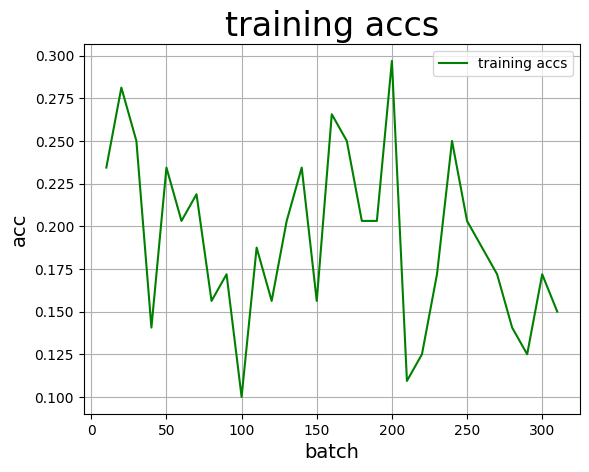

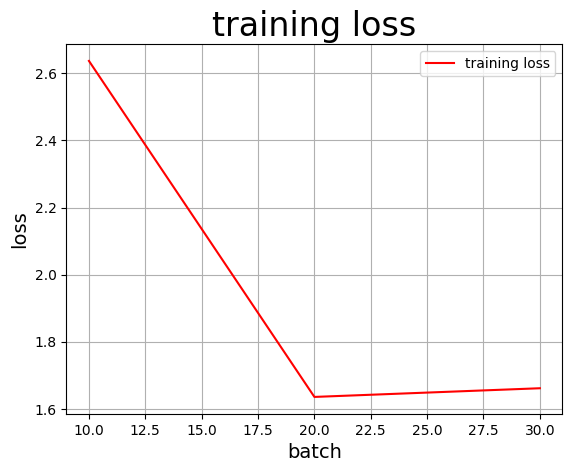

In [17]:
model = MyCNN()
model.train()
cross_entropy = paddle.nn.CrossEntropyLoss()
opt = paddle.optimizer.SGD(learning_rate=train_parameters["learning_strategy"]["lr"], parameters=model.parameters())
epoch_num = train_parameters["num_epochs"]

for epoch in range(epoch_num):
    for batch_id, data in enumerate(train_loader):
        img = data[0]
        label = data[1]
        predict = model(img)
        loss = cross_entropy(predict, label)
        acc = paddle.metric.accuracy(predict, label.reshape([-1, 1]))

        if batch_id != 0 and batch_id % 10 == 0:
            Batch = Batch + 10
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
            print("epoch:{},step:{},train_loss:{},train_acc:{}".format(epoch, batch_id, loss.numpy()[0],
                                                                       acc.numpy()[0]))

        loss.backward()
        opt.step()
        opt.clear_grad()

paddle.save(model.state_dict(), 'MyCNN')  #保存模型
draw_train_acc(Batchs, all_train_accs)
draw_train_loss(Batchs, all_train_loss)

## 5.模型评估

In [18]:
#模型评估
para_state_dict = paddle.load("MyCNN")
model = MyCNN()
model.set_state_dict(para_state_dict)  #加载模型参数
model.eval()  #验证模式

accs = []

for batch_id, data in enumerate(eval_loader()):  #测试集
    image = data[0]
    label = data[1]
    predict = model(image)
    acc = paddle.metric.accuracy(predict, label)
    accs.append(acc.numpy()[0])
    avg_acc = np.mean(accs)
print("当前模型在验证集上的准确率为:", avg_acc)

当前模型在验证集上的准确率为: 0.20117188
